<a href="https://colab.research.google.com/github/ekaterinatao/NER_biomed_domain/blob/main/active_learning/%D0%92%D0%9A%D0%A0_nerel_bio_RuBioBERT_active_learning_v6_bald.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Инструменты
Предобработанный дасасет [NEREL-BIO](https://huggingface.co/datasets/ekaterinatao/nerel_bio_ner_unnested)  

Исходная модель [RuBioBERT](https://huggingface.co/alexyalunin/RuBioBERT)

### Установка зависимостей

In [1]:
!pip install datasets accelerate evaluate wandb seqeval -q
!pip install baal -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 23.7 

In [2]:
import numpy as np
import pandas as pd
import random
from dataclasses import dataclass
import torch
from torch.nn.functional import softmax
import datasets
from datasets import Dataset, DatasetDict, concatenate_datasets
from transformers import (AutoTokenizer,
                          DataCollatorForTokenClassification,
                          AutoModelForTokenClassification,
                          TrainingArguments, Trainer,
                          pipeline)
from transformers.trainer_utils import get_last_checkpoint
import evaluate

import warnings
warnings.filterwarnings("ignore")

In [3]:
@dataclass
class TrainingConfig:
    seed = 64
    dataset = 'ekaterinatao/nerel_bio_ner_unnested'
    checkpoint = 'alexyalunin/RuBioBERT'
    hf_repo_id = "ekaterinatao/nerel-bio-RuBioBERT-al"
    n_labels = 45
    n_epochs = 10
    train_batch_size = 4
    eval_batch_size = 4
    device = "cuda" if torch.cuda.is_available() else "cpu"
    l_rate = 5e-05
    w_decay = 0.1
    warm_up = 0.1
    run_name="RuBioBERT_AL_v6"

config = TrainingConfig()

In [4]:
seed = config.seed

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Скачивание датасета

In [5]:
dataset = datasets.load_dataset(config.dataset)
dataset

Generating train split:   0%|          | 0/612 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/77 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/77 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'ner_tags'],
        num_rows: 612
    })
    valid: Dataset({
        features: ['id', 'words', 'ner_tags'],
        num_rows: 77
    })
    test: Dataset({
        features: ['id', 'words', 'ner_tags'],
        num_rows: 77
    })
})

In [6]:
# Labels
url = 'https://raw.githubusercontent.com/ekaterinatao/NER_biomed_domain/main/labels.txt'
tags = pd.read_csv(url, names=['tag']).values.tolist()
tags = [item for sublist in tags for item in sublist]
tag_to_id = {tag: i for i, tag in enumerate(tags)}
id_to_tag = {i: tag for i, tag in enumerate(tags)}

___
### Токенизация

In [7]:
tokenizer = AutoTokenizer.from_pretrained(config.checkpoint)

tokenizer_config.json:   0%|          | 0.00/413 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.75M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [8]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["words"], truncation=True, max_length=512, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_idxs = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_idxs:
            if word_idx is None:
                label_ids.append(-100) # Set the special tokens to -100.
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [9]:
tokenized_dataset = dataset.map(
    tokenize_and_align_labels, batched=True,
    #remove_columns = ['id', 'words', 'ner_tags']
)
tokenized_dataset

Map:   0%|          | 0/612 [00:00<?, ? examples/s]

Map:   0%|          | 0/77 [00:00<?, ? examples/s]

Map:   0%|          | 0/77 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 612
    })
    valid: Dataset({
        features: ['id', 'words', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 77
    })
    test: Dataset({
        features: ['id', 'words', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 77
    })
})

# Обучение модели

In [10]:
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [tags[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [tags[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [11]:
def choose_samples_bald(test_predictions, n_tokens) -> np.ndarray:
    """Функция для реализации стратеги отбора примеров для разметки
    на основе BALD
    https://github.com/baal-org/baal/tree/master"""

    from baal.active.heuristics import BALD

    # test_preds_new (DATASET_LEN, NUM_CLASSES, NUM_TOKENS)
    test_preds_new = np.transpose(test_predictions, (0, 2, 1))
    bald = BALD()
    scores = bald.get_uncertainties(test_preds_new)
    args = np.argsort(-scores)

    return args[:n_tokens]

In [12]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [13]:
model = AutoModelForTokenClassification.from_pretrained(
    config.checkpoint, num_labels=config.n_labels, id2label=id_to_tag, label2id=tag_to_id
)

config.json:   0%|          | 0.00/889 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at alexyalunin/RuBioBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
print(f'device is {config.device}')

device is cuda


In [15]:
from huggingface_hub import notebook_login
notebook_login()

In [16]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [17]:
import os
os.environ["WANDB_PROJECT"]="ner_bert_nerel_bio"

In [18]:
def train_and_predict(
    train_dataset, eval_dataset, test_dataset,
    model, tokenizer, data_collator, compute_metrics
):
    "Функция для тренировки модели, сохранения метрик и предсказаний"

    global config
    training_args = TrainingArguments(
        output_dir=config.hf_repo_id,
        num_train_epochs=config.n_epochs,
        learning_rate=config.l_rate,
        weight_decay=config.w_decay,
        warmup_ratio=config.warm_up,
        per_device_train_batch_size=config.train_batch_size,
        per_device_eval_batch_size=config.eval_batch_size,
        group_by_length=True,
        optim="adamw_torch",
        lr_scheduler_type="cosine",
        evaluation_strategy="epoch",
        seed = config.seed,
        data_seed = config.seed,
        push_to_hub=True,
        save_strategy="no",
        report_to="wandb",
        logging_steps=16,
        run_name=config.run_name,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    train_result = trainer.train()
    test_predictions = trainer.predict(
        test_dataset, metric_key_prefix="pred"
    )
    metrics = {}
    metrics['train_loss'] = train_result.metrics['train_loss']
    metrics.update(trainer.evaluate(eval_dataset))
    metrics.update(test_predictions.metrics)
    probas = test_predictions.predictions

    return metrics, probas, trainer

In [19]:
def run_active_learning(
    dataset, al_iters, init_train_size, choose_tokens,
    model, tokenizer, data_collator, compute_metrics
):
    "Функция для реализации цикла активного обучения"

    train_dataset = dataset['train'].select(
        random.sample(
            range(dataset['train'].num_rows),
            int(dataset['train'].num_rows * init_train_size)
        )
    )
    test_dataset = dataset['train'].filter(
        lambda s: s['id'] not in train_dataset['id']
    )
    all_metrics = {}

    for iter in range(al_iters):
        train_size = train_dataset.num_rows
        print(f'Training using {train_size} samples')

        eval_metrics, test_predictions, trainer = train_and_predict(
            train_dataset, dataset['valid'], test_dataset,
            model, tokenizer, data_collator, compute_metrics
        )

        all_metrics[f'{iter}'] = {'metrics': eval_metrics, 'train_size': train_size}

        if test_dataset.num_rows >= choose_tokens:
            new_args = choose_samples_bald(test_predictions, choose_tokens)
            new_train_samples = test_dataset.select(new_args)
            extended_train_dataset = concatenate_datasets(
                [train_dataset, new_train_samples]
            )

            train_dataset = extended_train_dataset
            test_dataset = dataset['train'].filter(
                lambda s: s['id'] not in train_dataset['id']
            )

    return all_metrics, trainer

In [20]:
metrics, trainer = run_active_learning(
    dataset=tokenized_dataset, al_iters=10, init_train_size=0.1, choose_tokens=61,
    model=model, tokenizer=tokenizer,
    data_collator=data_collator, compute_metrics=compute_metrics
)

Filter:   0%|          | 0/612 [00:00<?, ? examples/s]

Training using 61 samples


wandb: Currently logged in as: taoea. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.385500,2.925789,0.049296,0.001642,0.003177,0.158042
2,2.267000,2.012529,0.420856,0.343574,0.378309,0.537685
3,1.350600,1.434593,0.603119,0.562383,0.582039,0.693551
4,0.860100,1.240490,0.645208,0.620544,0.632636,0.727894
5,0.663400,1.124020,0.660775,0.640009,0.650226,0.742191
6,0.472900,1.049967,0.691080,0.670497,0.680633,0.770319
7,0.396700,1.000270,0.703881,0.689024,0.696374,0.781974
8,0.322900,1.009882,0.695569,0.684803,0.690144,0.779021
9,0.295800,1.000625,0.702774,0.689259,0.695951,0.784771
10,0.282500,1.000039,0.702774,0.689259,0.695951,0.784771


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]

Training using 122 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.490200,0.895397,0.721452,0.708255,0.714793,0.797514
2,0.336200,0.821199,0.733222,0.719981,0.726541,0.809635
3,0.254100,0.826239,0.744314,0.729128,0.736643,0.816939
4,0.206600,0.791567,0.744202,0.745075,0.744638,0.818182
5,0.142600,0.782247,0.748476,0.748827,0.748652,0.820668
6,0.101500,0.832721,0.751956,0.743668,0.747789,0.821911
7,0.087100,0.842717,0.749704,0.743199,0.746437,0.821911
8,0.059900,0.826276,0.755613,0.749765,0.752678,0.825019
9,0.049200,0.833293,0.752361,0.747420,0.749882,0.823155
10,0.052900,0.834474,0.751771,0.746482,0.749117,0.822533


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]

Training using 183 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.222200,0.702643,0.760395,0.759146,0.759770,0.831391
2,0.148100,0.714737,0.750528,0.750704,0.750616,0.827972
3,0.127600,0.732343,0.755592,0.760553,0.758065,0.832168
4,0.095600,0.725731,0.759070,0.765478,0.762261,0.832945
5,0.074800,0.795786,0.761837,0.758443,0.760136,0.833877
6,0.038900,0.804003,0.764555,0.769934,0.767235,0.836208
7,0.031800,0.809318,0.766157,0.764540,0.765348,0.836208
8,0.017100,0.826218,0.768564,0.769465,0.769014,0.838384
9,0.015200,0.835860,0.770994,0.772983,0.771987,0.839316
10,0.017500,0.835165,0.769411,0.771576,0.770492,0.838850


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]

Training using 244 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.158800,0.712452,0.755545,0.766886,0.761173,0.834965
2,0.169200,0.714020,0.758533,0.766182,0.762338,0.836519
3,0.089600,0.791877,0.753069,0.762430,0.757721,0.831080
4,0.060800,0.788482,0.772293,0.777908,0.775091,0.844444
5,0.023800,0.836357,0.753676,0.769231,0.761374,0.837607
6,0.019500,0.836217,0.775942,0.782129,0.779024,0.849728
7,0.013600,0.865793,0.773818,0.779081,0.776440,0.846309
8,0.012800,0.867528,0.780289,0.785413,0.782842,0.850350
9,0.007700,0.876020,0.779018,0.785413,0.782202,0.849728
10,0.007300,0.876950,0.778967,0.785178,0.782060,0.849573


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]

Training using 305 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.134800,0.750968,0.773660,0.778377,0.776011,0.847242
2,0.088600,0.815111,0.765299,0.765478,0.765389,0.838228
3,0.070700,0.760279,0.765545,0.768058,0.766799,0.843667
4,0.037900,0.847296,0.776836,0.773921,0.775376,0.844600
5,0.027900,0.841990,0.778116,0.778846,0.778481,0.848796
6,0.018100,0.867925,0.776092,0.779550,0.777817,0.849262
7,0.008600,0.851242,0.783904,0.783537,0.783720,0.854545
8,0.005700,0.863381,0.782141,0.784709,0.783423,0.853768
9,0.004500,0.870516,0.782558,0.784944,0.783749,0.854079
10,0.004300,0.872308,0.781674,0.784240,0.782955,0.853768


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]

Training using 366 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.107200,0.795498,0.766784,0.763368,0.765072,0.838228
2,0.036100,0.744958,0.784300,0.780253,0.782271,0.855167
3,0.076000,0.752556,0.775976,0.774156,0.775065,0.849573
4,0.046500,0.800463,0.778170,0.775797,0.776982,0.848796
5,0.015900,0.872621,0.774284,0.779550,0.776908,0.847397
6,0.009500,0.826139,0.780930,0.787523,0.784213,0.852681
7,0.007900,0.865930,0.784981,0.789400,0.787184,0.854856
8,0.002700,0.876648,0.788035,0.790807,0.789418,0.855789
9,0.001400,0.882040,0.788723,0.790572,0.789646,0.856099
10,0.002000,0.882235,0.788489,0.790338,0.789412,0.855944


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]

Training using 427 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.097600,0.735702,0.783220,0.783771,0.783495,0.851593
2,0.062500,0.770114,0.783345,0.780957,0.782149,0.852525
3,0.067700,0.761263,0.783784,0.788931,0.786349,0.855322
4,0.041300,0.774805,0.792551,0.788462,0.790501,0.858120
5,0.027900,0.792356,0.790627,0.795263,0.792938,0.859052
6,0.007800,0.802217,0.798782,0.799719,0.799250,0.863248
7,0.004600,0.826866,0.791135,0.799484,0.795288,0.861383
8,0.003900,0.831645,0.789730,0.797139,0.793417,0.860140
9,0.002000,0.838059,0.794323,0.800657,0.797477,0.862471
10,0.002800,0.839073,0.794090,0.800422,0.797244,0.862315


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]

Training using 488 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.017600,0.751081,0.790121,0.799015,0.794543,0.861694
2,0.065400,0.754742,0.797281,0.797842,0.797562,0.862005
3,0.034700,0.767996,0.789328,0.804878,0.797027,0.861228
4,0.030800,0.806979,0.794728,0.799015,0.796866,0.859984
5,0.014800,0.816684,0.794680,0.798780,0.796725,0.862782
6,0.015400,0.848590,0.798834,0.803705,0.801263,0.863869
7,0.002500,0.878727,0.786311,0.794794,0.790530,0.858275
8,0.005000,0.863352,0.794800,0.803002,0.798880,0.863092
9,0.001300,0.869059,0.796933,0.804409,0.800654,0.863559
10,0.002900,0.869593,0.796980,0.804644,0.800794,0.863559


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]

Training using 549 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.131400,0.778080,0.790057,0.786351,0.788199,0.856721
2,0.055100,0.781105,0.787611,0.793152,0.790372,0.859363
3,0.037200,0.781869,0.797383,0.800188,0.798783,0.862626
4,0.027900,0.799768,0.793257,0.794559,0.793907,0.860140
5,0.022100,0.903971,0.786378,0.793386,0.789867,0.856876
6,0.006900,0.871342,0.790989,0.798780,0.794866,0.859829
7,0.005400,0.869591,0.795676,0.802767,0.799206,0.862315
8,0.003700,0.879808,0.795259,0.802533,0.798879,0.861383
9,0.004800,0.879663,0.796089,0.802064,0.799065,0.861849
10,0.002100,0.880586,0.796184,0.802533,0.799346,0.862005


Filter:   0%|          | 0/612 [00:00<?, ? examples/s]

Training using 610 samples


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.073900,0.769362,0.796634,0.799250,0.797940,0.859829
2,0.055600,0.782635,0.794884,0.794325,0.794604,0.863248
3,0.020200,0.777335,0.801220,0.800657,0.800938,0.866822
4,0.012700,0.840738,0.795200,0.800422,0.797803,0.860917
5,0.015100,0.902017,0.789951,0.796435,0.793180,0.857964
6,0.007800,0.882442,0.801032,0.800657,0.800844,0.864025
7,0.003800,0.922470,0.804633,0.806520,0.805575,0.865268
8,0.000900,0.900275,0.802388,0.803705,0.803046,0.864180
9,0.000900,0.907401,0.803413,0.806051,0.804730,0.865579
10,0.003900,0.908211,0.804444,0.806520,0.805481,0.865890


In [21]:
wandb.finish()

eval/accuracy,▁▆▇▇▇███████████████████████████████████
eval/f1,▁▆▇▇▇▇▇█████████████████████████████████
eval/loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▂▂▁▁▁▂▁▁▂▂▁▁▁▁▁▁▂▂▁▂▂▂▁▂▂▂
eval/precision,▁▆▇▇▇▇██████████████████████████████████
eval/recall,▁▆▇▇▇▇▇▇████████████████████████████████
eval/runtime,█▁▂▁▂▁▁▅▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▁▁▁▁▁▂▂▁▂▁▁▁▁▁▁▁
eval/samples_per_second,▁█▆▇▆██▂██████▇████▆█▆█▅▇▇▇▇█▆▆█▅███████
eval/steps_per_second,▁█▆▇▆██▂██████▇████▆█▆█▅▇▇▇▇█▆▆█▅███████
train/epoch,▄▂▅▂▄▇▃▅▇▂▄▆█▂▄▆▇▂▃▅▆█▂▃▄▆▇▁▂▃▅▆▇█▂▃▄▅▆█
train/global_step,▁▁▂▁▂▃▂▃▃▁▂▃▄▂▃▄▅▁▂▃▅▆▂▃▄▅▆▁▂▃▄▅▆▇▂▃▄▅▆█
train/grad_norm,▃▃▄▃▁▃▃▇▃▂▁▃▅▃▂▁▄▃▁▁▁▃▃▆▃▁█▃▁▃▁▄▁▂▁▁▁▁▁▆


In [22]:
metrics

{'0': {'metrics': {'train_loss': 1.0297480553388596,
   'eval_loss': 1.0000391006469727,
   'eval_precision': 0.7027737924438068,
   'eval_recall': 0.6892589118198874,
   'eval_f1': 0.6959507459152261,
   'eval_accuracy': 0.7847707847707848,
   'eval_runtime': 0.8849,
   'eval_samples_per_second': 87.012,
   'eval_steps_per_second': 22.601,
   'epoch': 10.0,
   'pred_loss': 0.7819056510925293,
   'pred_precision': 0.7273767885532592,
   'pred_recall': 0.7065291247143122,
   'pred_f1': 0.7168014037726389,
   'pred_accuracy': 0.8206197854588796,
   'pred_runtime': 6.7642,
   'pred_samples_per_second': 81.459,
   'pred_steps_per_second': 20.402},
  'train_size': 61},
 '1': {'metrics': {'train_loss': 0.1746243697500998,
   'eval_loss': 0.8344738483428955,
   'eval_precision': 0.7517713745866793,
   'eval_recall': 0.7464821763602252,
   'eval_f1': 0.7491174393975053,
   'eval_accuracy': 0.8225330225330225,
   'eval_runtime': 1.0716,
   'eval_samples_per_second': 71.855,
   'eval_steps_per_s

### Отчет об обучении [ссылка](https://api.wandb.ai/links/taoea/5gmniszu)

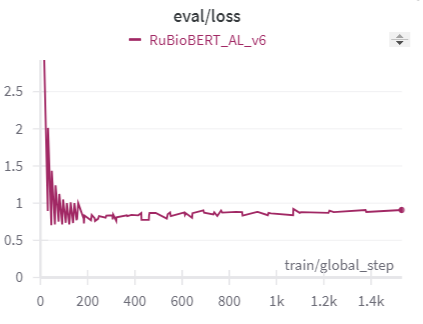    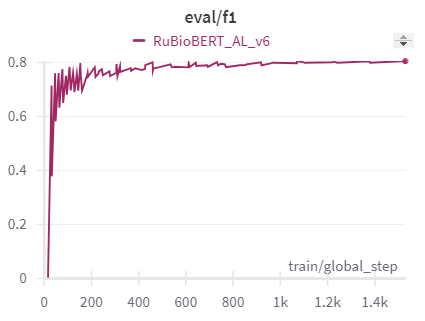

**Вывод**: На неполном датасете (50% и 70% данных) F1-score несколько хуже MNLP и рандомной стратегии. Однако на полном датасете качество стратегий сопоставимо.  

### Оценка качества на тестовой выборке

In [23]:
predictions = trainer.predict(test_dataset=tokenized_dataset["test"])

In [24]:
predictions.metrics

{'test_loss': 0.7804267406463623,
 'test_precision': 0.8302068302068302,
 'test_recall': 0.8248506571087216,
 'test_f1': 0.8275200767110152,
 'test_accuracy': 0.8892317687185317,
 'test_runtime': 0.8698,
 'test_samples_per_second': 88.525,
 'test_steps_per_second': 22.994}

Оценка модели на абстракте, которого не было в тестовом наборе

In [25]:
ner_bio = pipeline("ner", model=model, tokenizer=tokenizer, device=config.device)

In [26]:
abstract = """Цель. Оценить выживаемость у пациентов с болезнью Фабри (БФ) в зависимости от вида заместительной почечной терапии, и определить роль диализного скрининга в ранней диагностике БФ у родственников.
Материалы и методы. В исследование включали взрослых (старше 18 лет) пациентов с подтвержденным диагнозом БФ. Терминальная стадия хронической почечной недостаточности (тХПН) диагностировали в соответствии с рекомендациями Научного общества нефрологов России (2016) и KDIGO (2012). На основании опроса пробандов выявляли его родственников, которые могли унаследовать мутантный ген.
Результаты. У 50 (24,9%) из 201 обследованных пациентов с БФ диагностирована тХПН, в том числе у 48 (40%) из 120 мужчин и 2 (2,7%) из 81 женщин. Оценка кумулятивной частоты методом Каплана-Майера демонстрирует выраженное увеличение частоты регистрации тХПН к возрасту 20-30 лет, а к возрасту 50 лет ожидаемое количество пациентов с тХПН составляет 95%. Пяти из 50 больных с тХПН была выполнена трансплантация почки, в среднем, через 17 месяцев (диапазон от 7 до 70 месяцев) после инициации лечения гемодиализом. Умерло 15 (30%) из 50 пациентов, получавших лечение гемодиализом. Все умершие пациенты были мужского пола. Медиана возраста на момент летального исхода составила 45 (39; 58) лет. Среди пациентов, которым проведена трансплантация почки, летальных исходов зарегистрировано не было. У 44 (88%) из 50 пациентов диагноз БФ установлен, в среднем, через 1 год (диапазон от 0 до 12 лет) после начала лечения программным гемодиализом, в том числе у одного пациента – после трансплантации почки. Среди 44 пробандов, выявленных при всероссийском диализном скрининге, проведен семейный скрининг. Патогенная мутация в гене GLA диагностирована у 89 (57%) из 156 обследованных родственников диализных пробандов, в том числе у 18 детей моложе 18 лет, клинические проявления БФ имелись у 48 родственников. У 80,4% обследованных родственников диализных пробандов обнаружено поражение почек, преимущественно на ранних стадиях.
Заключение. ТХПН нередкое осложнение БФ, ассоциированное с неблагоприятным прогнозом. Однако диализный скрининг –  эффективный способ выявления пробандов с БФ, открывающий возможность установить диагноз БФ у родственников на ранних стадиях, когда лечение наиболее эффективно.
"""

In [27]:
ner_bio(abstract)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'entity': 'MEDPROC',
  'score': 0.3034224,
  'index': 1,
  'word': 'Цель',
  'start': 0,
  'end': 4},
 {'entity': 'MEDPROC',
  'score': 0.27537075,
  'index': 2,
  'word': '.',
  'start': 4,
  'end': 5},
 {'entity': 'SCIPROC',
  'score': 0.75078875,
  'index': 3,
  'word': 'Оцени',
  'start': 6,
  'end': 11},
 {'entity': 'FINDING',
  'score': 0.88273114,
  'index': 4,
  'word': '##ть',
  'start': 11,
  'end': 13},
 {'entity': 'PHYS',
  'score': 0.999706,
  'index': 5,
  'word': 'выжи',
  'start': 14,
  'end': 18},
 {'entity': 'PHYS',
  'score': 0.9996363,
  'index': 6,
  'word': '##ваемость',
  'start': 18,
  'end': 26},
 {'entity': 'PERSON',
  'score': 0.78796506,
  'index': 7,
  'word': 'у',
  'start': 27,
  'end': 28},
 {'entity': 'PERSON',
  'score': 0.9997842,
  'index': 8,
  'word': 'пациентов',
  'start': 29,
  'end': 38},
 {'entity': 'DISO',
  'score': 0.97384125,
  'index': 9,
  'word': 'с',
  'start': 39,
  'end': 40},
 {'entity': 'DISO',
  'score': 0.99986565,
  'index': 1